In [19]:
#Импорты библиотек
import pandas as pd
import numpy as np

from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model

import warnings 
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import metrics
from sklearn import preprocessing
import pickle
import datetime

import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import  GRU, Dense, TimeDistributed


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')


In [15]:
#Инициализируем эксперимент для comet.ml
experiment = Experiment(
  api_key="uUBF5EQVTcSyQ2FcYwgAB7bmg",
  project_name="motorica-intern-project",
  workspace="anasemina"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/anasemina/motorica-intern-project/6a545385bf054d1aa6f8dd8dd0434a74



## Задача
Необходимо обучить модель, которая сможет предсказывать жесты пилота с помощью показаний с оптомиографических датчиков.

In [20]:
random_seed = 42

## Формирование данных

Нам необходимо сформировать датасет, с которым мы будем работать.

Реализуем функцию для считывания наших данных.

In [21]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

Считываем таблицу метаданных по файлам всех наблюдений по разным пилотам:

In [22]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head(20)

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441
5,2023-06-20_13-30-15.palm,1,17928,17928,4435
6,2023-06-20_12-34-17.palm,1,17758,17758,4444
7,2023-09-30_08-06-44.palm,2,5693,5693,5509
8,2023-09-29_11-03-50.palm,2,5694,5694,5511
9,2023-09-29_09-20-47.palm,2,5690,5690,5507


Скачиваем данные показаний сенсоров и файлы с жестами пилотов в два списка:

In [23]:
data_list = []
target_list = []
for i in df_meta.index:
    path_data = './data/'+df_meta['montage'][i]
    data = read_omg_csv(path_data,
                    n_omg_channels=50,
                    n_acc_channels=3, 
                    n_gyr_channels=3, 
                    n_enc_channels=6, 
                    n_mag_channels=0)
    target_data = pd.read_csv(f'{path_data}.protocol.csv', index_col=0)
    data_list.append(data)
    target_list.append(target_data)

Скачиваем выбранные данные показаний сенсоров из списка:

In [24]:
j = 5 # id номер данных из таблицы метаданных
data = data_list[j]
data.head()

,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,10,6,6,1994,3077,2599,2709,5,8,6,...,18,0,0,0,0,0,0,0,0,70809
1,8,6,6,1975,3076,2567,2714,4,7,5,...,7,0,0,0,0,0,0,0,0,70842
2,8,6,6,1955,3078,2533,2728,5,7,6,...,4,0,0,0,0,0,0,0,0,70875
3,18,5,6,1954,3049,2516,2726,5,7,5,...,40,0,0,0,0,0,0,0,0,70908
4,9,6,6,1924,3034,2473,2761,10,8,7,...,29,0,0,0,0,0,0,0,0,70941


В итоге у нас есть следующая таблица, в которой:

1. [X features]:
    * '0', ..., '49' - каналы OMG датчиков
    * 'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
    * 'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
2. 'BUTTON' - не используется
3. 'SYNC' - синхронизация данных с протоколом
4. 'ts' - метка времени

Списки сенсоров:

In [8]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == data.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


Функция для визуализации показаний сенсоров:

In [9]:
def plot_sensors(df, cols, range_: range):
    '''
    Отображаем в указанном диапазоне показания ожидаемых сенсоров
    '''

    fig, axes = plt.subplots(10, 5, figsize=(20, 20), sharex=True, sharey=True)

    # Преобразуем 2D массив осей в 1D массив для удобства
    axes = axes.flatten()

    for i, column in enumerate(cols):
        axes[i].plot(df[column].values[range_])
        axes[i].set_title(column)

    # Удаляем лишние подграфики, если их меньше 50
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    #experiment.log_figure(figure=plt)
    plt.show()
    

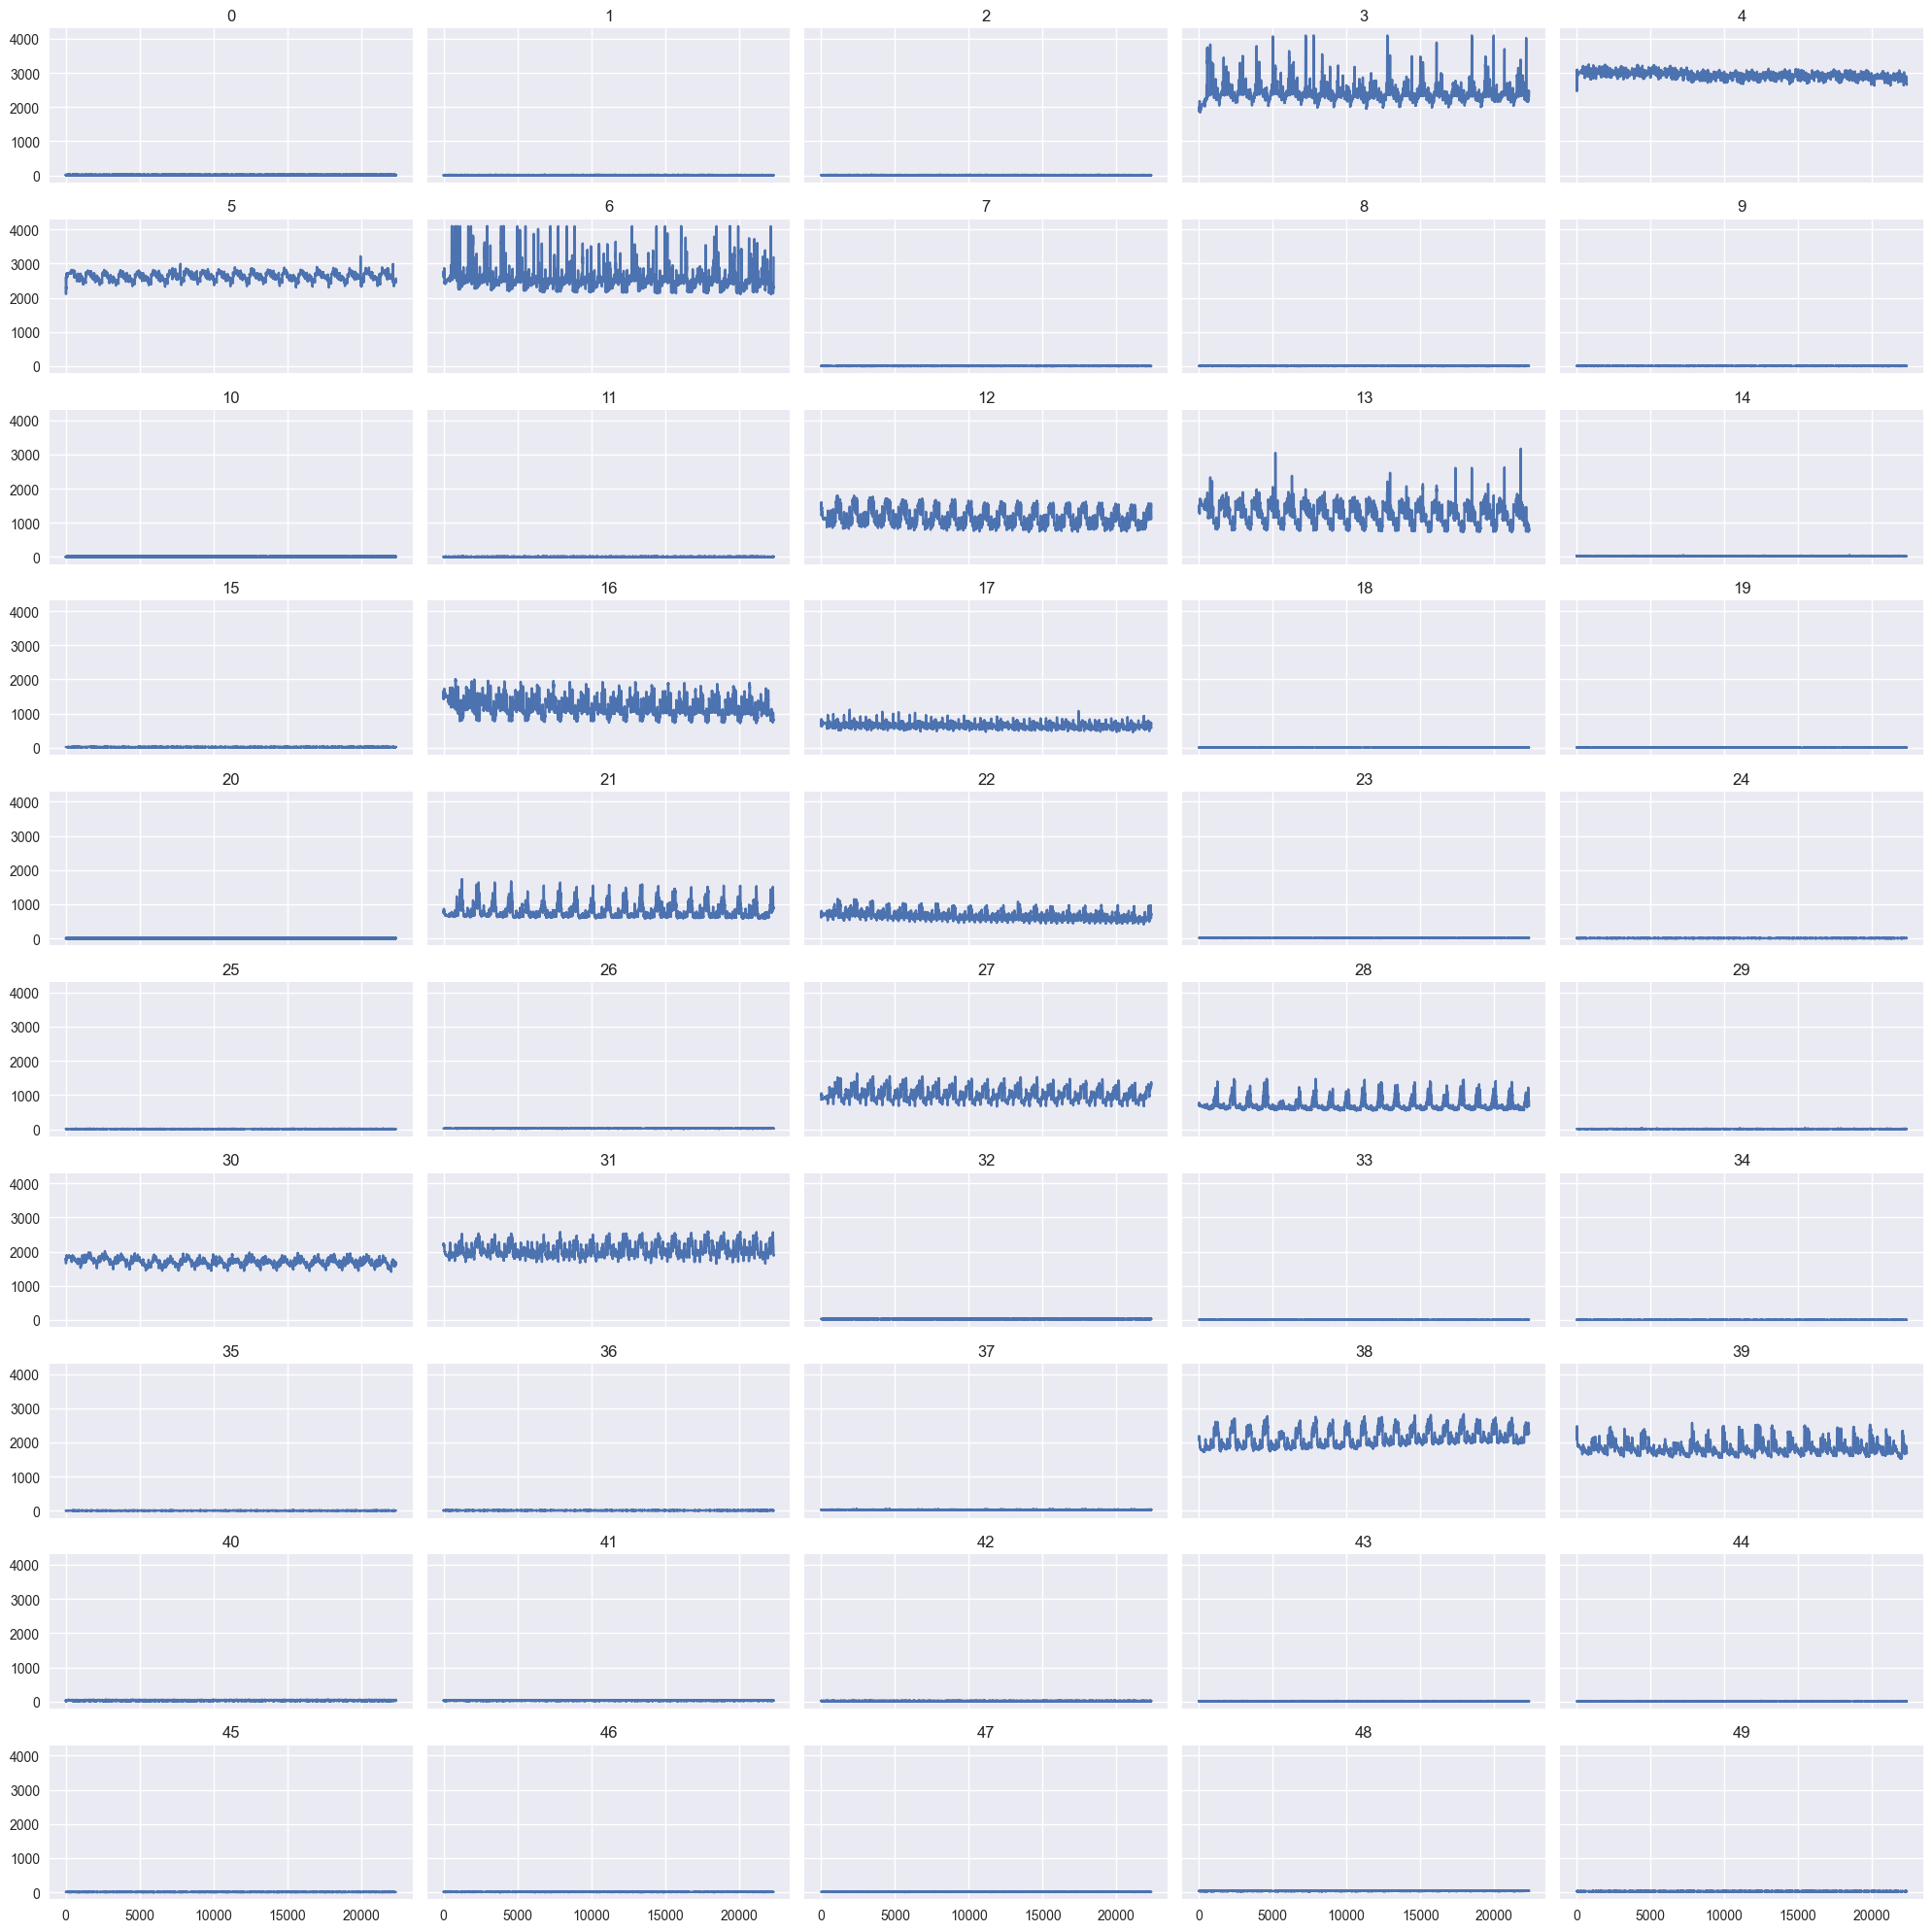

In [10]:
plot_sensors(data, OMG_CH, range(data.shape[0]))


In [22]:
#path_data = './data/2023-05-15_17-12-24.palm'
#data = read_omg_csv(path_data,
                    #n_omg_channels=50,
                    #n_acc_channels=3, 
                    #n_gyr_channels=3, 
                    #n_enc_channels=6, 
                    #n_mag_channels=0)
#print(f'Data shape: {data.shape}')
#data.head()

Удалим признаки, которые не будем использовать:

In [11]:
drop_features = ['ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'ts']
data = data.drop(drop_features, axis=1)

In [12]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,SYNC
0,10,6,6,1994,3077,2599,2709,5,8,6,...,29,14,18,6,6,9,13,36,30,0
1,8,6,6,1975,3076,2567,2714,4,7,5,...,27,13,6,6,6,9,12,34,28,0
2,8,6,6,1955,3078,2533,2728,5,7,6,...,29,13,7,7,6,10,13,36,30,0
3,18,5,6,1954,3049,2516,2726,5,7,5,...,28,24,9,6,6,8,12,34,28,0
4,9,6,6,1924,3034,2473,2761,10,8,7,...,28,14,6,7,5,9,14,37,30,0


In [29]:
data['SYNC'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22361 entries, 0 to 22360
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       22361 non-null  int64
 1   1       22361 non-null  int64
 2   2       22361 non-null  int64
 3   3       22361 non-null  int64
 4   4       22361 non-null  int64
 5   5       22361 non-null  int64
 6   6       22361 non-null  int64
 7   7       22361 non-null  int64
 8   8       22361 non-null  int64
 9   9       22361 non-null  int64
 10  10      22361 non-null  int64
 11  11      22361 non-null  int64
 12  12      22361 non-null  int64
 13  13      22361 non-null  int64
 14  14      22361 non-null  int64
 15  15      22361 non-null  int64
 16  16      22361 non-null  int64
 17  17      22361 non-null  int64
 18  18      22361 non-null  int64
 19  19      22361 non-null  int64
 20  20      22361 non-null  int64
 21  21      22361 non-null  int64
 22  22      22361 non-null  int64
 23  23      223

Заметим, что в данных нет целевой переменной. Давайте получим ее.

In [9]:
#Для начала считываем необходимые данные
#target_data = pd.read_csv(f'{path_data}.protocol.csv', index_col=0)
#print(f'Target data shape: {target_data.shape}')
#Посмотрим правильно ли они считались
#target_data.head(10)

Считываем соответствующие данные для целевой переменной:

In [27]:
target_data = target_list[j]
target_data.head()

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


Закодируем целевую переменную в соответствии с baseline:

In [320]:
le = preprocessing.LabelEncoder()

# FIT
le.fit(
    target_data[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
target_data['gesture'] = le.transform(
    target_data[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

Получилось следующее:
* Neutral - 0
* Open - 1
* Pistol - 2
* Thumb - 3
* OK - 4
* Grab - 5

Добавим столбец таргета к датасету с обучающими данными. Для этого нам нужно их синхронизировать, используя столбец SYNC из таблицы data, его значение соответсвует индексу выполняемого жества из таблицы target_data.

In [321]:
#Формируем целевой признак
data['gesture'] = data['SYNC'].apply(lambda x: target_data['gesture'].loc[x])
#Удаляем ненужный столбец
data = data.drop('SYNC', axis=1)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,gesture
0,10,6,6,1994,3077,2599,2709,5,8,6,...,29,14,18,6,6,9,13,36,30,0
1,8,6,6,1975,3076,2567,2714,4,7,5,...,27,13,6,6,6,9,12,34,28,0
2,8,6,6,1955,3078,2533,2728,5,7,6,...,29,13,7,7,6,10,13,36,30,0
3,18,5,6,1954,3049,2516,2726,5,7,5,...,28,24,9,6,6,8,12,34,28,0
4,9,6,6,1924,3034,2473,2761,10,8,7,...,28,14,6,7,5,9,14,37,30,0


In [322]:
data.shape

(22361, 51)

In [323]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22361 entries, 0 to 22360
Data columns (total 51 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0        22361 non-null  int64
 1   1        22361 non-null  int64
 2   2        22361 non-null  int64
 3   3        22361 non-null  int64
 4   4        22361 non-null  int64
 5   5        22361 non-null  int64
 6   6        22361 non-null  int64
 7   7        22361 non-null  int64
 8   8        22361 non-null  int64
 9   9        22361 non-null  int64
 10  10       22361 non-null  int64
 11  11       22361 non-null  int64
 12  12       22361 non-null  int64
 13  13       22361 non-null  int64
 14  14       22361 non-null  int64
 15  15       22361 non-null  int64
 16  16       22361 non-null  int64
 17  17       22361 non-null  int64
 18  18       22361 non-null  int64
 19  19       22361 non-null  int64
 20  20       22361 non-null  int64
 21  21       22361 non-null  int64
 22  22       22361 non-nul

Теперь посмотрим на графики наших временных рядов.

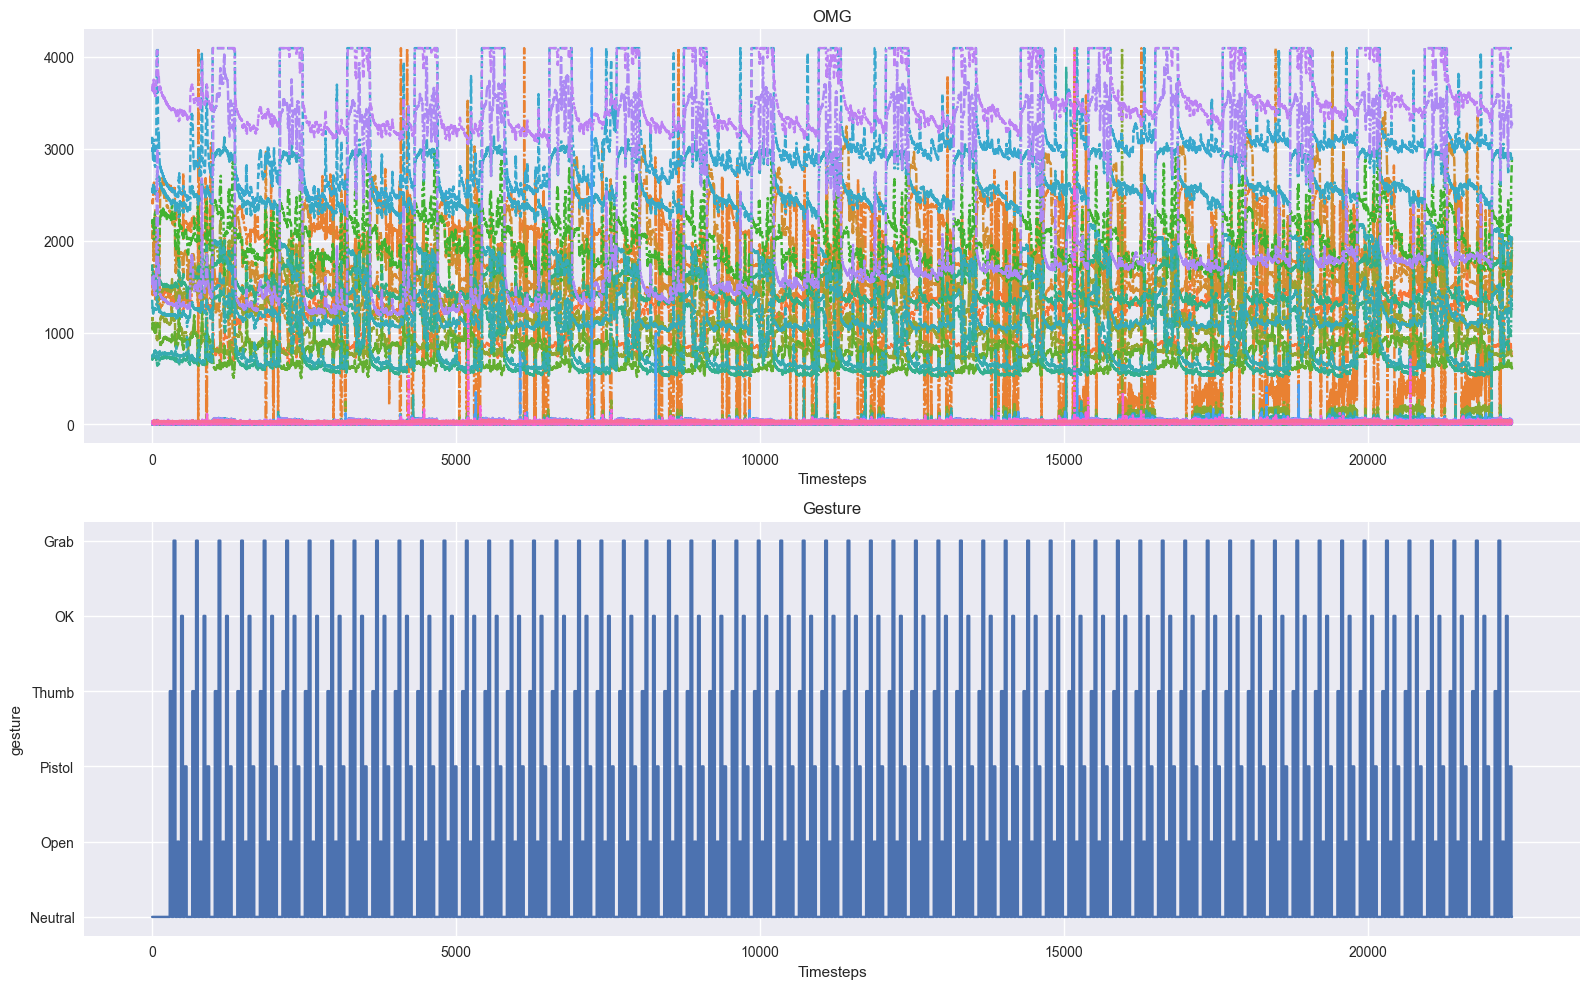

In [280]:
#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1), ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

#experiment.log_figure(figure=plt)

## Анализ данных

Рассмотрим наши временные ряды более локально, будем просматривать каждые 100 временных шагов.

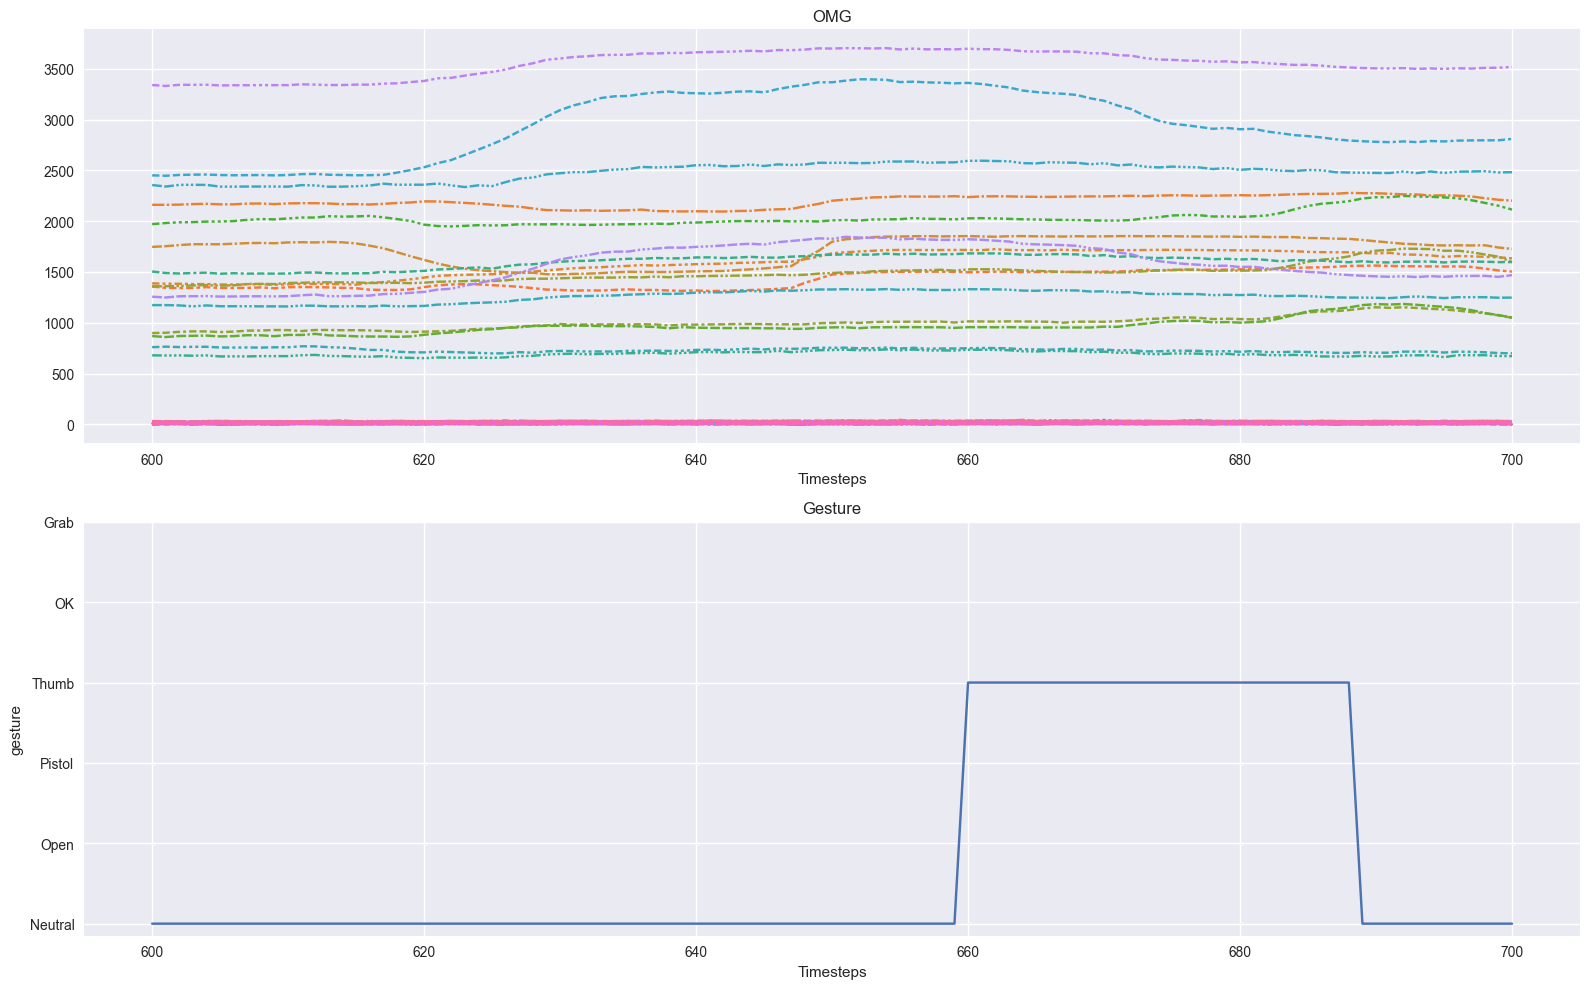

In [281]:
sample_number = 6

#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1).iloc[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'].iloc[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

#experiment.log_figure(figure=plt)

### Удаление задержки

Если мы просмотрим несколько таких сэмплов, то сразу станет понятным, что в данных присутствует задержка, от которой необходимо избавиться.

Реализуем следующую идею: воспользуемся шифтером(сместим наши данные) на n количество временных шагов влево, число n подберем таким образом, чтобы взаимная корреляция временного ряда суммы абсолютных значений производных наших признаков с временным рядом выполнения жестов(число 1 - жест выполняется, число 0 - нейтральное положение руки) была максимальна.

n: 16, cor: 0.2627571058266064


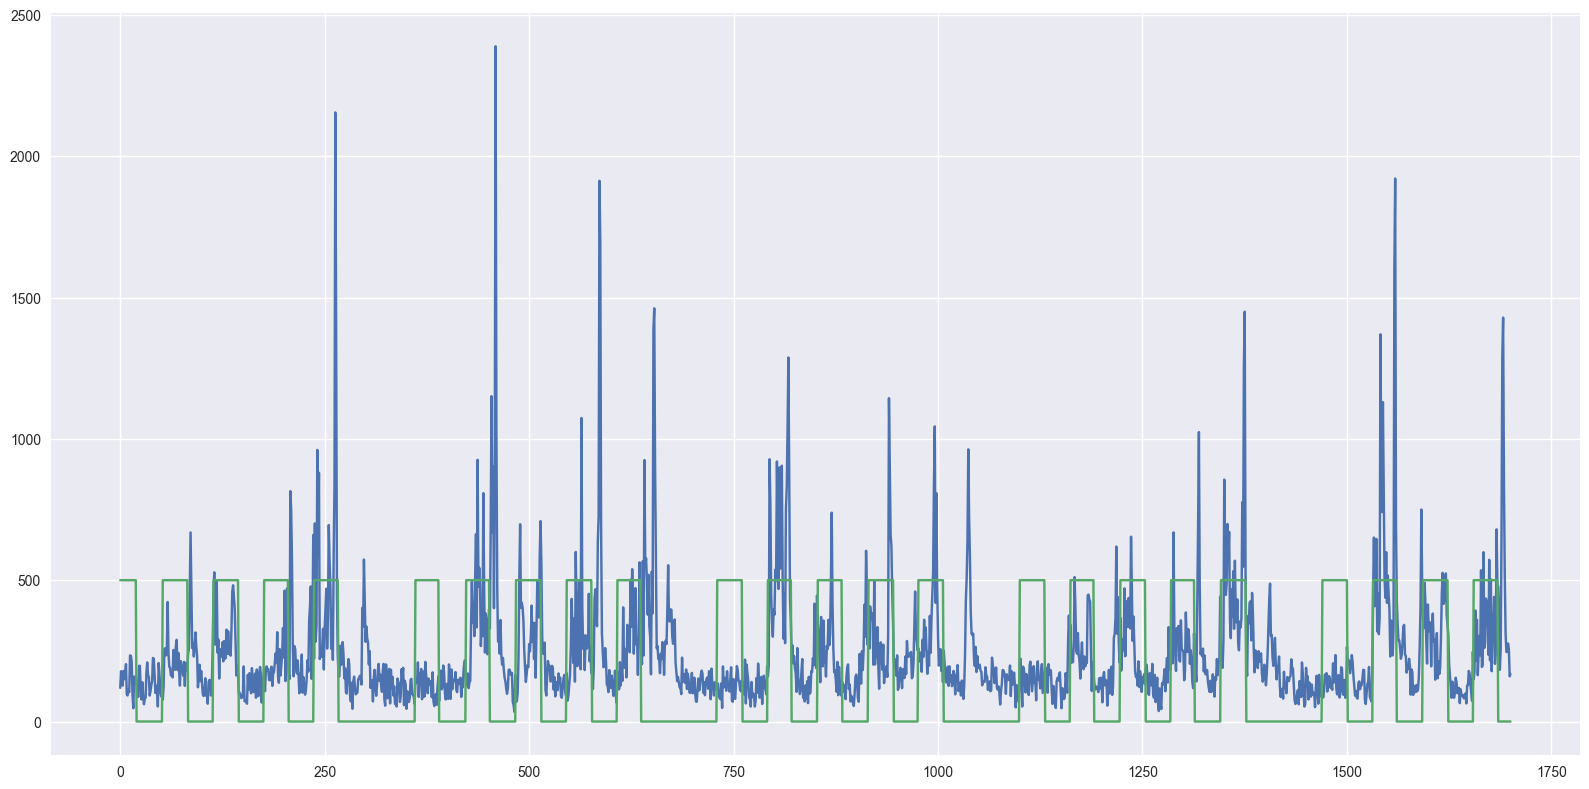

In [324]:
def data_shifter(data, n):
    """Смещает данные на n единиц

    Args:
        data: Данные
        n: Кол-во единиц

    Returns:
        X: Смещенные данные
    """
    X = data.drop('gesture', axis=1) #Матрица наблюдений
    y = data['gesture'] #Вектор правильных ответов
    #Смещаем данные
    X = X.iloc[n:].reset_index(drop=True)
    X['gesture'] = y.iloc[:-n].reset_index(drop=True)
    return X

def get_sum_derivative(data):
    """Возвращает сумму абсолютных значений производных

    Args:
        data: Наши данные

    Returns:
        result: Серия сумм абсолютных значений производных
    """
    result = abs(data.drop('gesture', axis=1).diff()).sum(axis=1)
    return result

def get_best_shifter(data, res_plot=False):
    #Формируем ряд выполнения жестов.
    gestures = data['gesture'].apply(lambda x: 500 if x > 0 else 0)
    #Ряд производных
    derivatives = get_sum_derivative(data)
    #Словарь с результатом
    result = {'n': 0, 'cor': 0}
    #Находим лучший шифтер
    for n in range(1, 41):
        cor = np.corrcoef(derivatives.iloc[n:].values, gestures.iloc[:-n].values)[0][1]
        if cor > result['cor']:
            result['n'] = n
            result['cor'] = cor
            
    if res_plot: #Если необходимо строим график с полученным сдвигом для первых 2000 таймстепов.
        fig, axes = plt.subplots(1, 1, figsize=(16, 8))
        sns.lineplot(derivatives.iloc[result['n']:].values[300:2001], ax=axes, legend=False)
        sns.lineplot(gestures.iloc[:-result['n']].values[300:2001], ax=axes, legend=False)
        plt.tight_layout()
    #Выводим результат    
    print(f'n: {result["n"]}, cor: {result["cor"]}')
    #Возвращаем словарь с найденным n и корреляцией
    return result
    
#Применяем полученную функцию
n = get_best_shifter(data, res_plot=True)['n']

#experiment.log_figure(figure=plt)

Теперь к нашим данным применяем функцию data_shifter со значением n равным тому, что получили при использовании get_best_shifter.

In [325]:
#Применяем функцию
data = data_shifter(data, n)
print(f'Data shape: {data.shape}')
data

Data shape: (22345, 51)


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,gesture
0,4,4,7,1949,2478,2134,2692,5,7,6,...,29,14,6,6,6,9,13,36,30,0
1,8,6,7,1944,2497,2153,2655,5,7,6,...,27,13,5,6,6,9,13,33,28,0
2,9,5,7,1933,2514,2155,2631,5,6,6,...,26,13,6,6,5,9,13,34,27,0
3,8,5,6,1911,2543,2162,2613,4,4,6,...,27,24,5,6,6,9,12,34,27,0
4,8,5,6,1886,2599,2180,2604,2,7,6,...,27,14,6,6,6,9,12,33,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22340,9,5,5,2349,2709,2477,2366,4,6,5,...,24,13,6,6,6,8,13,36,26,2
22341,8,5,5,2375,2675,2495,2613,4,7,6,...,27,13,5,6,6,9,13,36,27,2
22342,9,0,5,2402,2678,2521,2711,4,8,6,...,27,12,8,6,6,8,13,36,27,2
22343,8,5,5,2429,2675,2541,2895,5,6,6,...,27,14,6,5,6,8,12,35,26,2


Давайте посмотрим на графики после смещения.

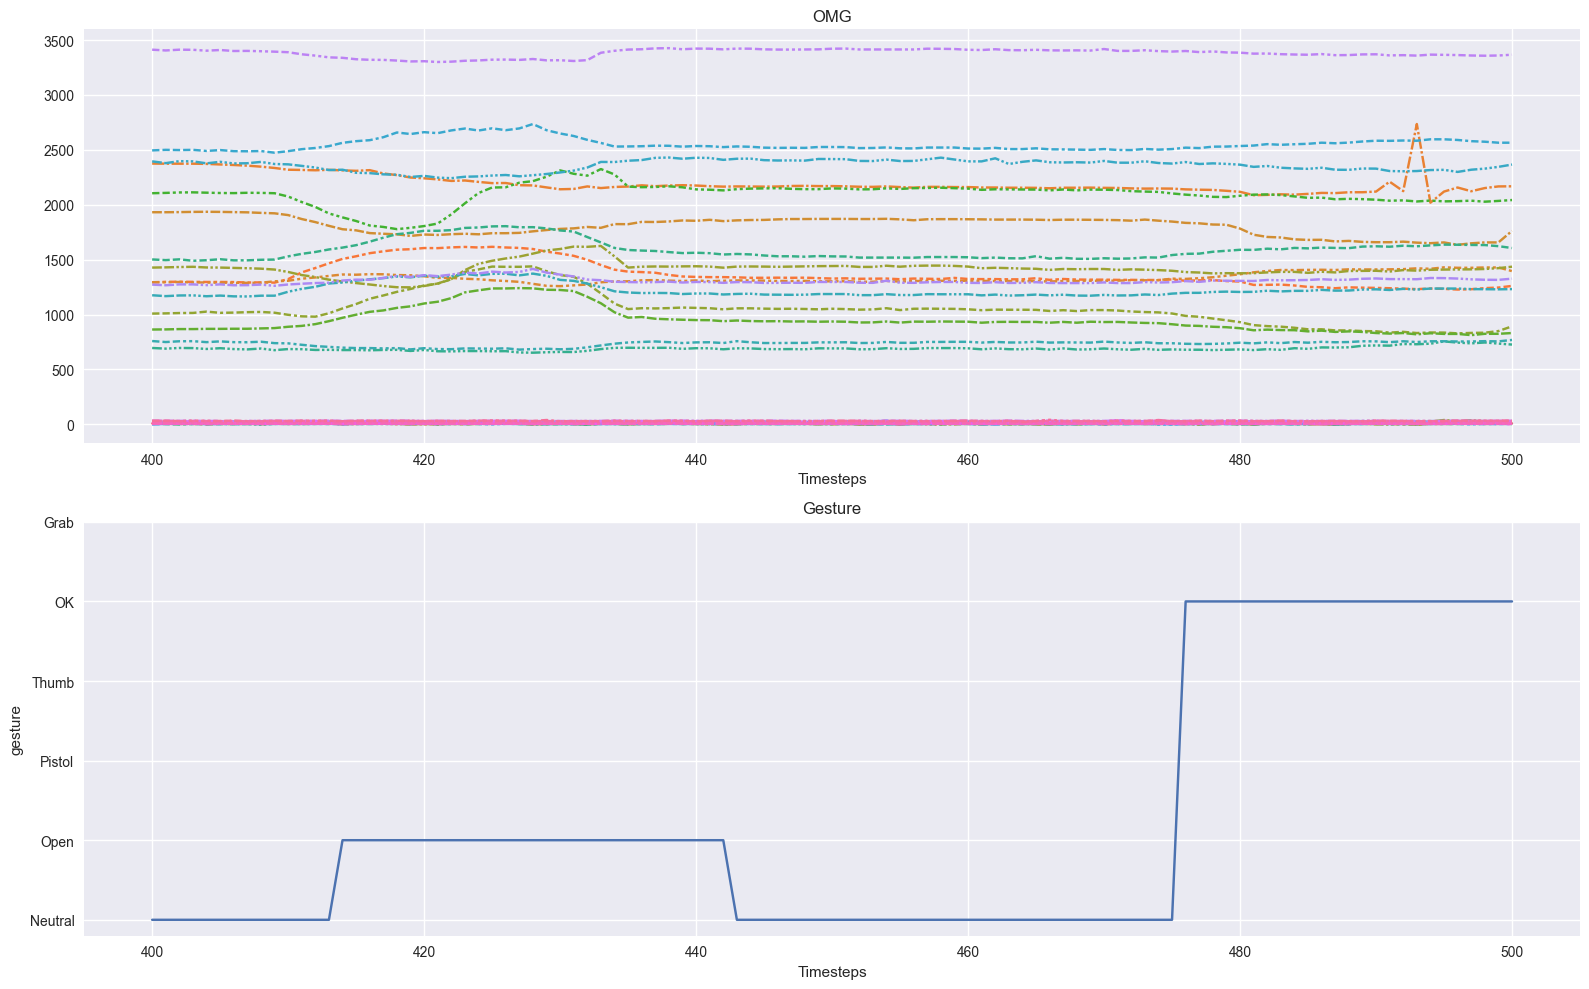

In [284]:
sample_number = 4

#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1).iloc[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'].iloc[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

#experiment.log_figure(figure=plt)

### Сбалансированность классов

Посмотрим на распределение целевой переменной.

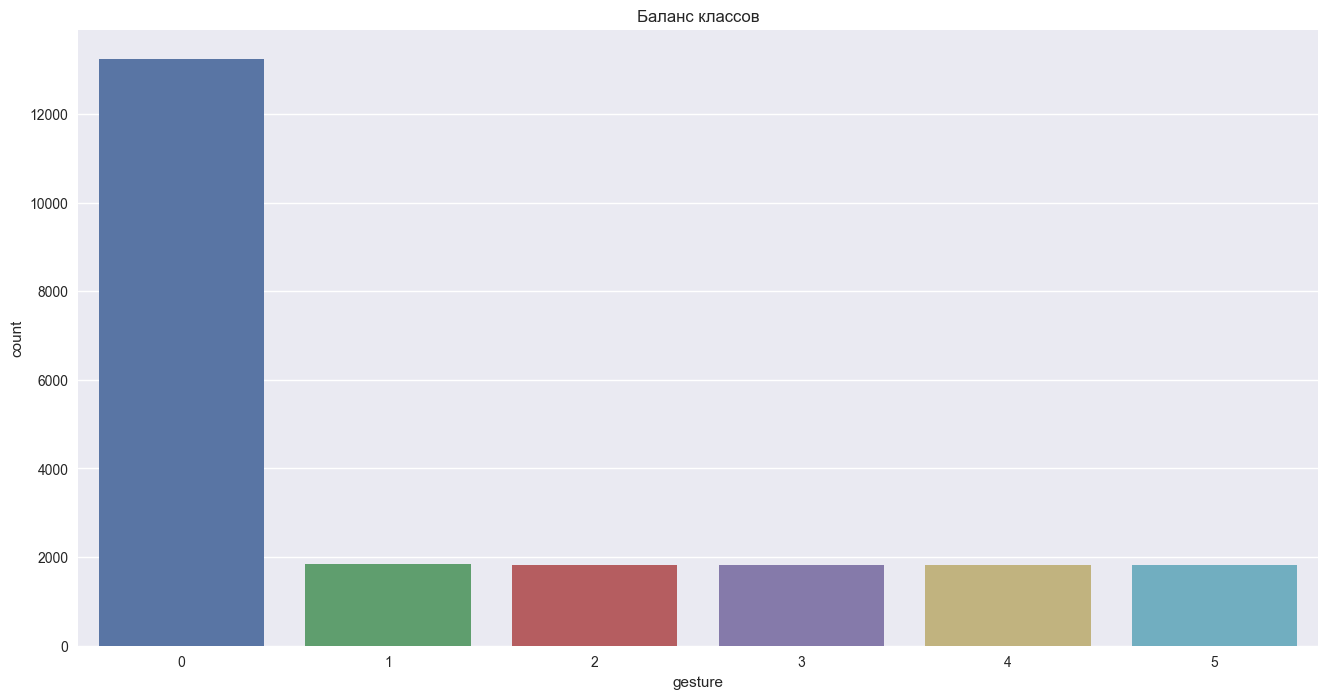

In [285]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='gesture', ax=ax)
ax.set_title('Баланс классов')
experiment.log_figure(figure=plt)

Видим, что классы несбалансированны. Перед подачей данных в модель данный нужно будет стандартизировать. Если мы используем рекурентную сеть, то в данном случае это обязательно, чтобы упростить последующее умножение входной матрицы.

## Предобработка данных. Feature engineering.


Давайте сгенерируем признаки из нашего датасета с различными таймстепами:

1. Производные (разницы) для каждого признака и сумму производных (разниц).
2. Тренды (не изменяется - 0, убывает - 1, возрастает - 2).
3. Средние значения по показаниям с датчиков.

In [326]:
def get_trend(derivative):
    #Получает тренд из производной
    if derivative > 0:
        return 2
    elif derivative < 0:
        return 1
    else:
        return 0

def create_features(data, n_diff, sum_create=False, trend_create=False, mean_create=False):
    """Изначально создает признаки производных для наших данных, также можно добавить тренды, среднии значения.

    Args:
        data: Наши данные
        n_diff (_type_): Кол-во таймстепов для разницы
        sum_create (bool, optional): Если True, то добавит признак суммы производных. Defaults to False.
        trend_create (bool, optional): Если True, то добавит признаки трендов. Defaults to False.
        mean_create (bool, optional): Если True, то добавит признаки средних. Defaults to False.


    Returns:
        data: Данные со сгенерированными признаками
    """
    #Имена признаков
    col_names = [str(x) for x in range(50)]
    #Для каждого признака добавляем признак производных
    for col in col_names:
        data[f'{col}_diff_{n_diff}'] = data[col].diff(n_diff).fillna(0)
        if trend_create:
            data[f'{col}_trend_{n_diff}'] = data[f'{col}_diff_{n_diff}'].apply(get_trend)
        if mean_create:
            data[f'mean_{n_diff}'] = data.drop('gesture', axis=1).shift(n_diff).mean(axis=1).fillna(0)
        
        
    #Если надо, то добавляем сумму производных 
    if sum_create:
        data[f'sum_diff_{n_diff}'] = data[[f'{col}_diff_{n_diff}' for col in col_names]].sum(axis=1)
    #Возвращаем наши данные
    return data

def get_features(data, n_diff, count, sum_create=False, trend_create=False, mean_create=False):
    #Добавляет признаки к нашим данным от n_diff до n_diff * count отступов
    for i in range(1, count + 1):
        data = create_features(data, n_diff * i, sum_create=sum_create, trend_create=trend_create, mean_create=mean_create)
    #Возвращаем данные со сгенерированными признаками    
    return data
        
data = get_features(data, 5, 3, sum_create=True, trend_create=True, mean_create=True)
print(f'Data shape: {data.shape}')
print(f'Итоговые столбцы:\n {data.columns.tolist()}')
data.head()

Data shape: (22345, 357)
Итоговые столбцы:
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 'gesture', '0_diff_5', '0_trend_5', 'mean_5', '1_diff_5', '1_trend_5', '2_diff_5', '2_trend_5', '3_diff_5', '3_trend_5', '4_diff_5', '4_trend_5', '5_diff_5', '5_trend_5', '6_diff_5', '6_trend_5', '7_diff_5', '7_trend_5', '8_diff_5', '8_trend_5', '9_diff_5', '9_trend_5', '10_diff_5', '10_trend_5', '11_diff_5', '11_trend_5', '12_diff_5', '12_trend_5', '13_diff_5', '13_trend_5', '14_diff_5', '14_trend_5', '15_diff_5', '15_trend_5', '16_diff_5', '16_trend_5', '17_diff_5', '17_trend_5', '18_diff_5', '18_trend_5', '19_diff_5', '19_trend_5', '20_diff_5', '20_trend_5', '21_diff_5', '21_trend_5', '22_diff_5', '22_trend_5', '23_diff_5', '23_trend_5', '24_diff_5', '24

,0,1,2,3,4,5,6,7,8,9,...,45_trend_15,46_diff_15,46_trend_15,47_diff_15,47_trend_15,48_diff_15,48_trend_15,49_diff_15,49_trend_15,sum_diff_15
0,4,4,7,1949,2478,2134,2692,5,7,6,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,8,6,7,1944,2497,2153,2655,5,7,6,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,9,5,7,1933,2514,2155,2631,5,6,6,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,8,5,6,1911,2543,2162,2613,4,4,6,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,8,5,6,1886,2599,2180,2604,2,7,6,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


Подготовим данные для подачи в рекуретную сеть с GRU слоем.
Для этого нам нужно установить количество временных шагов (лаг) и поделить данные на тренировочную и тестовую выборки.
Так как количество временных шагов должно быть достаточным, чтобы в них попадали показания датчиков обязательно на нейтральном положении руки и при выполнении жеста, то, судя по анализу данных выше, длина которых кратна 40, и в этот лаг попадает и жест и нейтральное положение, то пока выберем лаг равный 40. Посмотрим как это выглядит на графике:

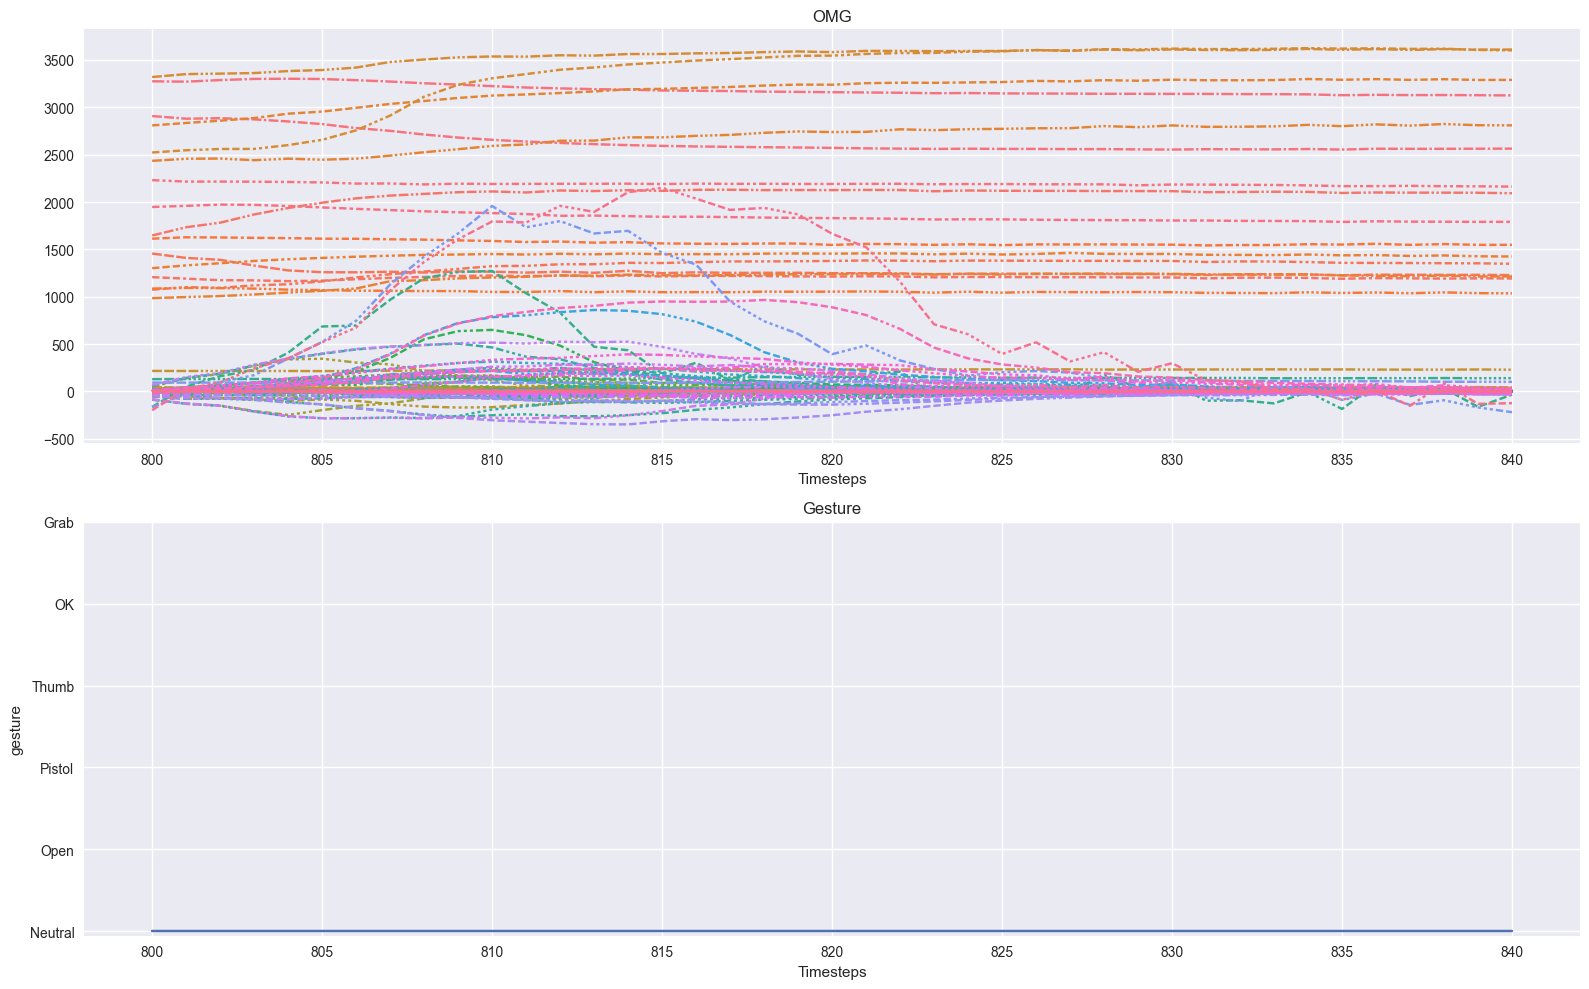

In [248]:
#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1).iloc[800:841], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'].iloc[800:841], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()
#experiment.log_figure(figure=plt)

In [327]:
#зафиксируем переменные - кол-во временных шагов в одном лаге и кол-во классов, рассчитаем количество образцов в данных
time_steps = 40
num_classes = 6

In [328]:
#записываем в переменную остаток от деления длины датасета на кол-во временных шагов
remainder = len(data)%time_steps
#отрезаем от данных первые строки (time steps) по количеству остатка, чтобы длина данных была кратна временному лагу
#отрезаем от начала данных, потому что, как правило, сначала идет задержка или нейтральное состояние датчиков
data = data[remainder:]
print(data.shape)

(22320, 357)


In [329]:
num_samples = data.shape[0] // time_steps
print(num_samples)

558


In [330]:
#разобьем данные на тренировочную и тестовые выборки, кратные временному лагу, в пропорции 0.8/0.2
X = data.drop('gesture', axis=1)
y = data['gesture']

test_start_index = (round(num_samples* 0.8)*time_steps)

In [331]:
X_train = X.iloc[:test_start_index]
X_test = X.iloc[test_start_index:].reset_index(drop=True)
y_train = y.iloc[:test_start_index]
y_test = y.iloc[test_start_index:]

assert data.shape[0] == X_train.shape[0] + X_test.shape[0]

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (17840, 356)
Test shape: (4480, 356)


Стандартизируем данные перед подачей в модель:

In [332]:
# Создание объекта StandardScaler
scaler = preprocessing.StandardScaler()

# Масштабируем обучающие данные
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Масштабируем тестовые данные
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

## Отбор признаков

Реализуем отбор признаков. Количество k признаков подобрано опытным путем.

In [333]:
selector = SelectKBest(f_classif, k=50)
selector.fit(X_train_scaled, y_train)

selected_features = selector.get_feature_names_out()
X_train = X_train_scaled[selected_features]
X_test = X_test_scaled[selected_features]

print(f'Отобранные признаки: {selector.get_feature_names_out()}')
print(f'Train Data shape: {X_train.shape}')
print(f'Test Data shape: {X_test.shape}')

log_model(experiment, model=selector, model_name='Feature Selector')

Отобранные признаки: ['3' '4' '6' '12' '16' '17' '21' '22' '27' '31' '32' '37' 'mean_5'
 '21_diff_5' '21_trend_5' '22_diff_5' '27_trend_5' 'mean_10' '3_diff_10'
 '12_diff_10' '12_trend_10' '21_diff_10' '21_trend_10' '22_diff_10'
 '22_trend_10' '27_diff_10' '27_trend_10' '28_diff_10' '38_trend_10'
 '39_diff_10' '3_diff_15' '3_trend_15' '6_diff_15' '12_diff_15'
 '12_trend_15' '16_diff_15' '17_diff_15' '17_trend_15' '21_diff_15'
 '21_trend_15' '22_diff_15' '22_trend_15' '27_diff_15' '27_trend_15'
 '28_diff_15' '28_trend_15' '38_diff_15' '38_trend_15' '39_diff_15'
 'sum_diff_15']
Train Data shape: (17840, 50)
Test Data shape: (4480, 50)


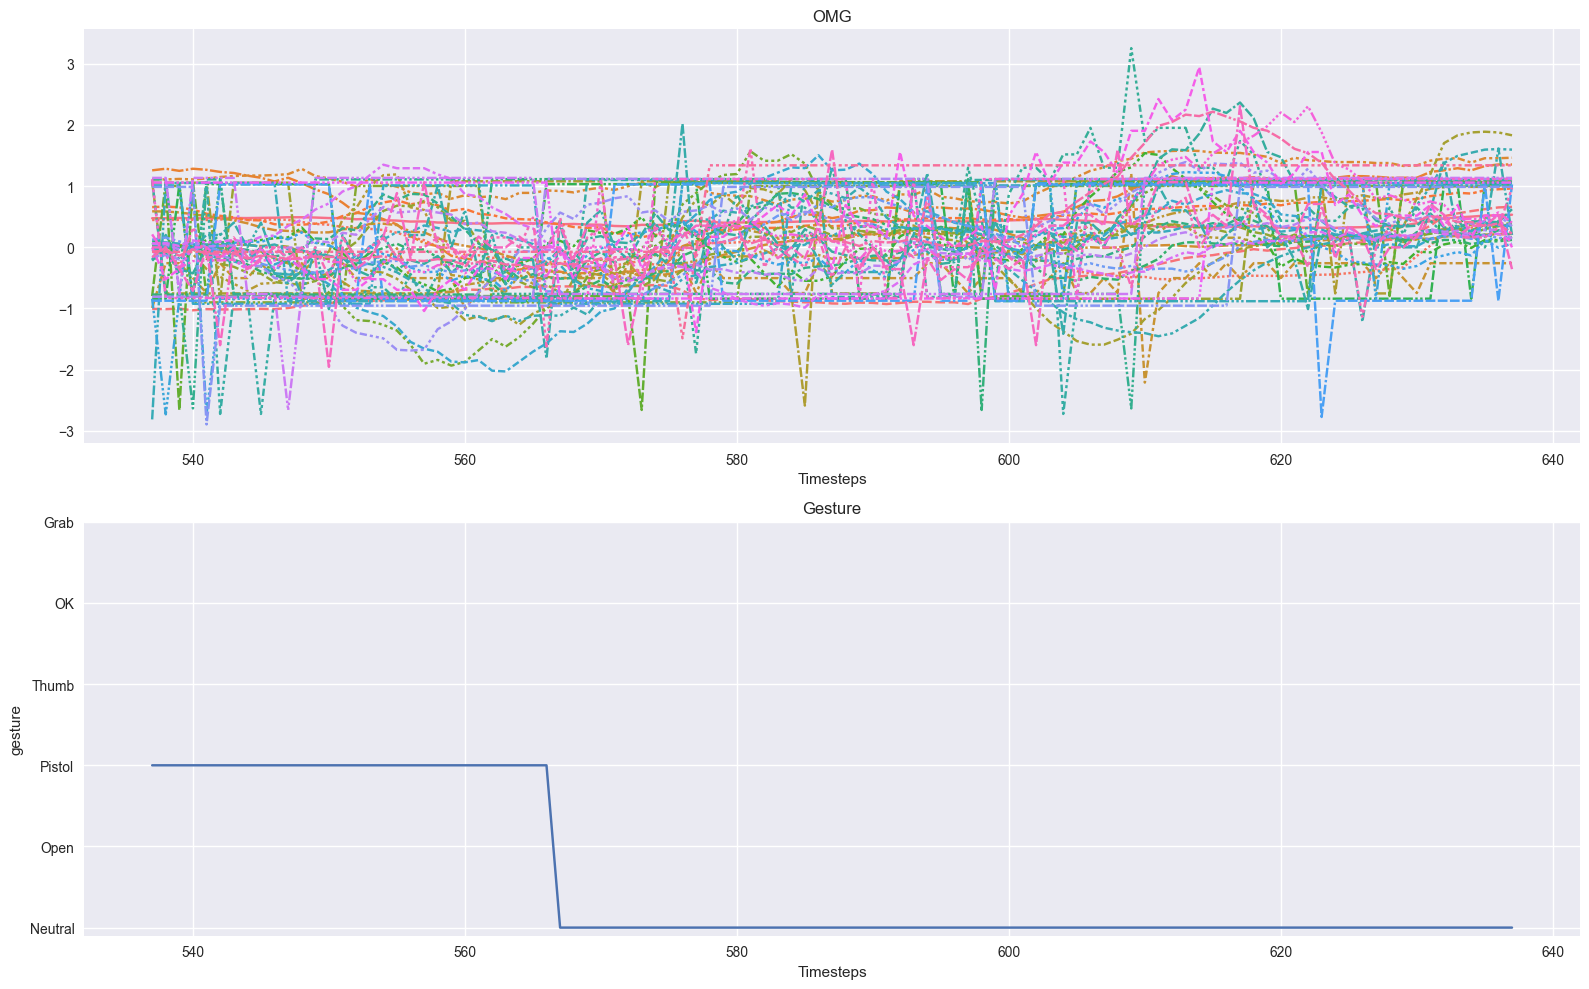

In [294]:
#посмотрим на данные после преобразований
sample_number = 5

#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(X_train[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(y_train[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()
#experiment.log_figure(figure=plt)

Видны уже более явные изменения в показаниях датчиков даже для труднопредсказываемого жеста Thumb.

## Modelling: Рекурентная сеть со слоем GRU

### Подготовим данные для подачи в модель 

In [334]:
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (17840, 50)
Test shape: (4480, 50)


In [335]:
num_factors = len(X_train.columns)

Делим данные по количеству временных шагов.

In [336]:
X_train = X_train.values
X_test = X_test.values

In [337]:
X_train_gru = X_train.reshape(X_train.shape[0]//time_steps,time_steps,num_factors)
X_test_gru = X_test.reshape(X_test.shape[0]//time_steps,time_steps,num_factors)

In [338]:
print(X_train_gru.shape)
print(X_test_gru.shape)

(446, 40, 50)
(112, 40, 50)


In [339]:
# Преобразуем целевую переменную в one-hot encoding
num_classes = 6 # Количество классов жестов
y_train_cat= to_categorical(y_train, num_classes=num_classes)
y_test_cat=to_categorical(y_test,num_classes=num_classes)
y_test_cat

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [340]:
print(y_train_cat.shape)
print(y_test_cat.shape)

(17840, 6)
(4480, 6)


In [341]:
#целевую переменную также делим на лаги 
y_train_gru = y_train_cat.reshape(y_train_cat.shape[0]//time_steps,time_steps,num_classes)
y_test_gru = y_test_cat.reshape(y_test_cat.shape[0]//time_steps,time_steps,num_classes)

print(X_train_gru.shape)
print(X_test_gru.shape)
print(y_train_gru.shape)
print(y_test_gru.shape)

(446, 40, 50)
(112, 40, 50)
(446, 40, 6)
(112, 40, 6)


Создаем модель (размер слоев и learning_rate подобраны экспериментально)

In [342]:
# Создаем модель
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(GRU(100, input_shape=(time_steps, num_factors), return_sequences=True))
model.add(Dense(100, activation='relu'))
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))
model.summary()

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 40, 100)        │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 40, 100)        │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 40, 6)          │           606 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,306 (219.95 KB)

 Trainable params: 56,306 (219.95 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
#%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [100]:
#log_dir = "logs/fit11/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [343]:
# Обучаем модель
model.fit(X_train_gru, y_train_gru, epochs=20, batch_size=40, validation_split=0.2)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5063 - loss: 1.2803 - val_accuracy: 0.7475 - val_loss: 0.7424
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7853 - loss: 0.6274 - val_accuracy: 0.7967 - val_loss: 0.5630
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8348 - loss: 0.4501 - val_accuracy: 0.8039 - val_loss: 0.5204
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8559 - loss: 0.3833 - val_accuracy: 0.8122 - val_loss: 0.5073
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8697 - loss: 0.3327 - val_accuracy: 0.8256 - val_loss: 0.4716
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8838 - loss: 0.2899 - val_accuracy: 0.8106 - val_loss: 0.4810
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8869 - loss: 0.2937 - val_accuracy: 0.8333 - val_loss: 0.4615
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9004 - loss: 0.2486 - val_accuracy: 0.8314 - val_loss: 0.4522


In [344]:
predictions_train = model.predict(X_train_gru)
predictions_test = model.predict(X_test_gru)
print(predictions_train.shape)
print(predictions_test.shape)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
(446, 40, 6)
(112, 40, 6)


In [345]:
y_train_proba=np.reshape(predictions_train,(predictions_train.shape[0]*time_steps,6))
y_test_proba = np.reshape(predictions_test,(predictions_test.shape[0]*time_steps,6))

print(y_train_proba.shape)
print(y_test_proba.shape)

(17840, 6)
(4480, 6)


Так как модель возвращает массив со значениями вероятностей классов, то перекодируем результат в классы.

In [346]:
y_pred_train=np.argmax(y_train_proba,axis=1)
print(y_pred_train.shape)

y_pred_test = np.argmax(y_test_proba,axis=1)
print(y_pred_test.shape)

(17840,)
(4480,)


In [347]:
print(metrics.classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10548
           1       0.94      0.93      0.93      1473
           2       0.96      0.92      0.94      1432
           3       0.90      0.90      0.90      1471
           4       0.97      0.92      0.94      1459
           5       0.96      0.96      0.96      1457

    accuracy                           0.95     17840
   macro avg       0.95      0.93      0.94     17840
weighted avg       0.95      0.95      0.95     17840



In [116]:
# Получаем отчёт как словарь
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)

# Доступ к F1-score для "macro avg"
train_avg_f1 = report['macro avg']['f1-score']

print(f"Macro avg F1-score: {train_avg_f1}")

Macro avg F1-score: 0.9569318016505157


In [348]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      2590
           1       0.83      0.89      0.86       374
           2       0.79      0.54      0.64       401
           3       0.70      0.65      0.67       371
           4       0.86      0.69      0.77       374
           5       0.82      0.75      0.78       370

    accuracy                           0.81      4480
   macro avg       0.80      0.74      0.76      4480
weighted avg       0.81      0.81      0.80      4480



In [118]:
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)

# Доступ к F1-score для "macro avg"
test_avg_f1 = report['macro avg']['f1-score']

print(f"Macro avg F1-score: {test_avg_f1}")

Macro avg F1-score: 0.7527078979370915


In [18]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anasemina/motorica-intern-project/6a545385bf054d1aa6f8dd8dd0434a74
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (9.70 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)


# Real-time inference

In [102]:
import time
import serial
from IPython.display import clear_output

In [103]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

In [104]:
# Собираем функции в словарь
functions_dict = {
    'read_omg_csv':read_omg_csv,
    "data_shifter": data_shifter,
    "get_sum_derivative": get_sum_derivative,
    "get_best_shifter": get_best_shifter,
    "get_trend":get_trend,
    "create_features":create_features,
    "get_features":get_features
}

In [105]:
# Сохраняем их в файл
with open('functions.pkl', 'wb') as f:
    pickle.dump(functions_dict, f)

## Inference Utils: Put your code here

In [72]:
def preprocessing(x):
    x=data
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y